In [35]:
from contextlib import chdir
import glob

from matplotlib import pylab as plt
from matplotlib.ticker import MaxNLocator
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import table
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
import numpy as np


from ciao_contrib import runtool as rt
from sherpa.astro import ui

import utils
import chandra_helpers
import model_helpers

The target list is made by hand by Carl by looking through the literature and seeing which targets have either astroseismic ages or are part of a binary with a WD that we can used for age dating. 

Note: In the proposal, we have a target "40 Eri A". Simbad does not recognize that name, and this I'm renaming it "40 Eri", which seems to be the name of the corresponding target in SIMBAD.

The list also includes **NGC 752**, which is a cluster that might have about 40 stars with X-ray detections. However, it's located at 450 pc. Even though the Chandra observation is quite long (135 ks) most of the stars detected are probably binaries, or flaring or in some other way special which would make them unsuitable for our purposes. Given how easy it is these days to run the pipeline over a number of targets in the same ObsID, I suggest that I'll just try that to check. I just need Carl to send me an updated membership list. The data has originally been published by Ignazio, but that was way before GAIA, so the membership list looks considerably different now. It's worth a day of work or so to run the ciao_contrib scripts over the data and see what we get.

**Alpha Cen** has an observing campaign by Tom Ayres, which covers alpha Cen A and B. The same targets are also part of the Hamburg campaign by Jan Robrade et al which uses XMM. Both have published results and for now we'll plan to just cite that data and not re-reduce it ourselves again here. So, for now, I'm just removing all alpha Cen observations from the list, but we can always come back and run the notebook again with those included.

Similarly, **proxima Cen** has a dedicated article by [Wargelin et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.3281W/abstract) which presents strong hints of a stellar cycle. Their analysis contains a much wider range of X-ray data than we attempt to cover here (ASCA, dozens of Swift observations), so it does not seem useful for use to re-analyze. Instead, we'll get more infomration by citing their paper. It is, however, true that a few Chandra observations of Proxima Cen are more recent than that article. Those are covered by [Fuhrmeister et al (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...663A.119F/abstract), together with HST/STIS. Again, that article has| far more detail than we attempt here, so there is little benefit of re-analysing for us. 


The images and flux table in this notebook are almost ready for science. I still need to do some cosmetic enhancements (e.g. use Greek letters for the names the stars) as well some twaeking of the numbers, e.g. the size of the extraction regions, and the bandpasses that we use for fitting and for images.

In [2]:
targets = table.Table.read('solar_like_age_targets.txt', 
                          format='ascii.no_header', names=['object'], 
                          # Default is to fail if there is only one column in guessing.
                          guess=False, delimiter=',')

In [3]:
coords = utils.coords_from_simbad(targets['object'], 
                                  'data/ages/simbad.ecsv')


In [4]:
chandra_obs = chandra_helpers.search_chandra_archive(coords, 'data/ages/obsids.ecsv')

As I said above, alpha Can A and B and proxima Cen are covered with far more extensive data (e.g. including ASCA, Swift) than what we do here, so we don't re-analyse those stars.

In [5]:
for star in ['alpha Cen', 'Proxima Cen']:
    chandra_obs = chandra_obs[~np.array([t.startswith(star) 
                                     for t in chandra_obs['object']])]

In [6]:
chandra_obs

ObsId,obs_date,RA,Dec,Instrument,Exposure,Grating,object
int64,str19,float64,float64,str6,float64,str4,str11
12740,2011-07-12T00:40:00,295.441666666667,50.5958055555556,ACIS-S,7.95,NONE,16 Cyg A
16647,2016-02-06T12:46:00,295.460416666667,50.5213888888889,ACIS-I,35.33,NONE,16 Cyg A
18756,2016-02-07T22:13:00,295.460416666667,50.5213888888889,ACIS-I,38.57,NONE,16 Cyg A
21167,2020-03-19T17:28:00,295.454583333333,50.5254444444444,HRC-I,35.05,NONE,16 Cyg A
23188,2020-03-20T12:58:00,295.454583333333,50.5254444444444,HRC-I,35.31,NONE,16 Cyg A
12740,2011-07-12T00:40:00,295.441666666667,50.5958055555556,ACIS-S,7.95,NONE,16 Cyg B
16647,2016-02-06T12:46:00,295.460416666667,50.5213888888889,ACIS-I,35.33,NONE,16 Cyg B
18756,2016-02-07T22:13:00,295.460416666667,50.5213888888889,ACIS-I,38.57,NONE,16 Cyg B
21167,2020-03-19T17:28:00,295.454583333333,50.5254444444444,HRC-I,35.05,NONE,16 Cyg B


In [7]:
chandra_helpers.download_repro('data/ages', chandra_obs['ObsId'])

In [8]:
for obsid in np.unique(chandra_obs['ObsId']):
    with chdir(f'data/ages/{obsid}'):
        evt2 = glob.glob('repro/*evt2*')[0]
        # This binning selects pretty large regions. It may not always cover
        # the whole FOV, but certainly the part where the PSF is good.
        if 'acis' in evt2:
            binning = "[bin x=2700:5700:2,y=2000:6000:2][energy=400:4000]"
        else:
            binning = "[bin x=10000:20000:5,y=10000:20000:5]"
        rt.dmcopy(infile=f"{evt2}{binning}",
              outfile='image.fits', option='image', clobber=True)
        rt.mkpsfmap('image.fits', 'psfmap.fits', energy=1.49, ecf=0.393, clobber=True)
        rt.wavdetect(infile='image.fits', outfile='source_list.fits', scellfile='source_cell.fits',
                 imagefile='image.fits', defnbkgfile='background.fits',
                 expfile=None, psffile='psfmap.fits', clobber=True)

Looking manually, I don't see enough sources in 2MASS or GAIA that match the X-ray sources in any of the ObsIDs. There might be three or four in some cases, but not with large count numbers, so there would still be considerable uncertainty. Given that, I prefer to leave it at the coordinates that Chandra assigned.

In [8]:
utils.coords_for_obs(chandra_obs, coords)

In [9]:
chandra_helpers.remove_outside_of_FOV('data/ages', chandra_obs)

In [10]:
# Manual inspection shows that 16 Cyg A is right on the edge of the FOW in ObsID 12740. Very few photons are visible.
# Since we have plenty of better data for that target, we drop this ObsID.
chandra_obs = chandra_obs[chandra_obs['ObsId'] != 12740]

In [11]:
chandra_obs['off_axis_angle'] =[chandra_helpers.chan_coords(f"data/ages/{row['ObsId']}", 
                                                                row['coord'])[0] for row in chandra_obs]
chandra_obs['off_axis_angle'].unit = u.arcmin
chandra_obs['off_axis_angle'].format = '.2f'

In [12]:
chandra_obs['object', 'ObsId', 'obs_date', 'Instrument', 'Exposure', 'Grating', 'off_axis_angle']

object,ObsId,obs_date,Instrument,Exposure,Grating,off_axis_angle
,,,,,,arcmin
str11,int64,str19,str6,float64,str4,float64
16 Cyg A,16647,2016-02-06T12:46:00,ACIS-I,35.33,NONE,0.56
16 Cyg A,18756,2016-02-07T22:13:00,ACIS-I,38.57,NONE,0.56
16 Cyg A,21167,2020-03-19T17:28:00,HRC-I,35.05,NONE,0.22
16 Cyg A,23188,2020-03-20T12:58:00,HRC-I,35.31,NONE,0.23
16 Cyg B,16647,2016-02-06T12:46:00,ACIS-I,35.33,NONE,0.13
16 Cyg B,18756,2016-02-07T22:13:00,ACIS-I,38.57,NONE,0.13
16 Cyg B,21167,2020-03-19T17:28:00,HRC-I,35.05,NONE,0.63
16 Cyg B,23188,2020-03-20T12:58:00,HRC-I,35.31,NONE,0.64


In [13]:
for row in chandra_obs:
    chandra_helpers.cutout_image(f"data/ages/{row['ObsId']}", row['coord'],
                                f"data/ages/{row['object'].replace(' ', '_')}_{row['ObsId']}_image.fits")

Some of the coordinates are a bit off, so we are using 95% PSF to make sure that we capture the source even in that case.

In [14]:
chandra_obs['psf_radius'] = [chandra_helpers.psf_of_coord(f"data/ages/{row['ObsId']}", 
                                                     row['coord'],
                                                     psffrac=0.95) * u.arcsec for row in chandra_obs]

Set MJD-END to 57424.961979 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 57426.402789 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 58928.169120 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 58928.982731 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 55581.681736 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 55990.405845 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 55921.499213 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 56098.307650 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 57250.386655 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 56065.584387 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 57066.029213 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 58964.938183 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 58829.207315 from DATE-END'. [astropy.wcs.wcs]


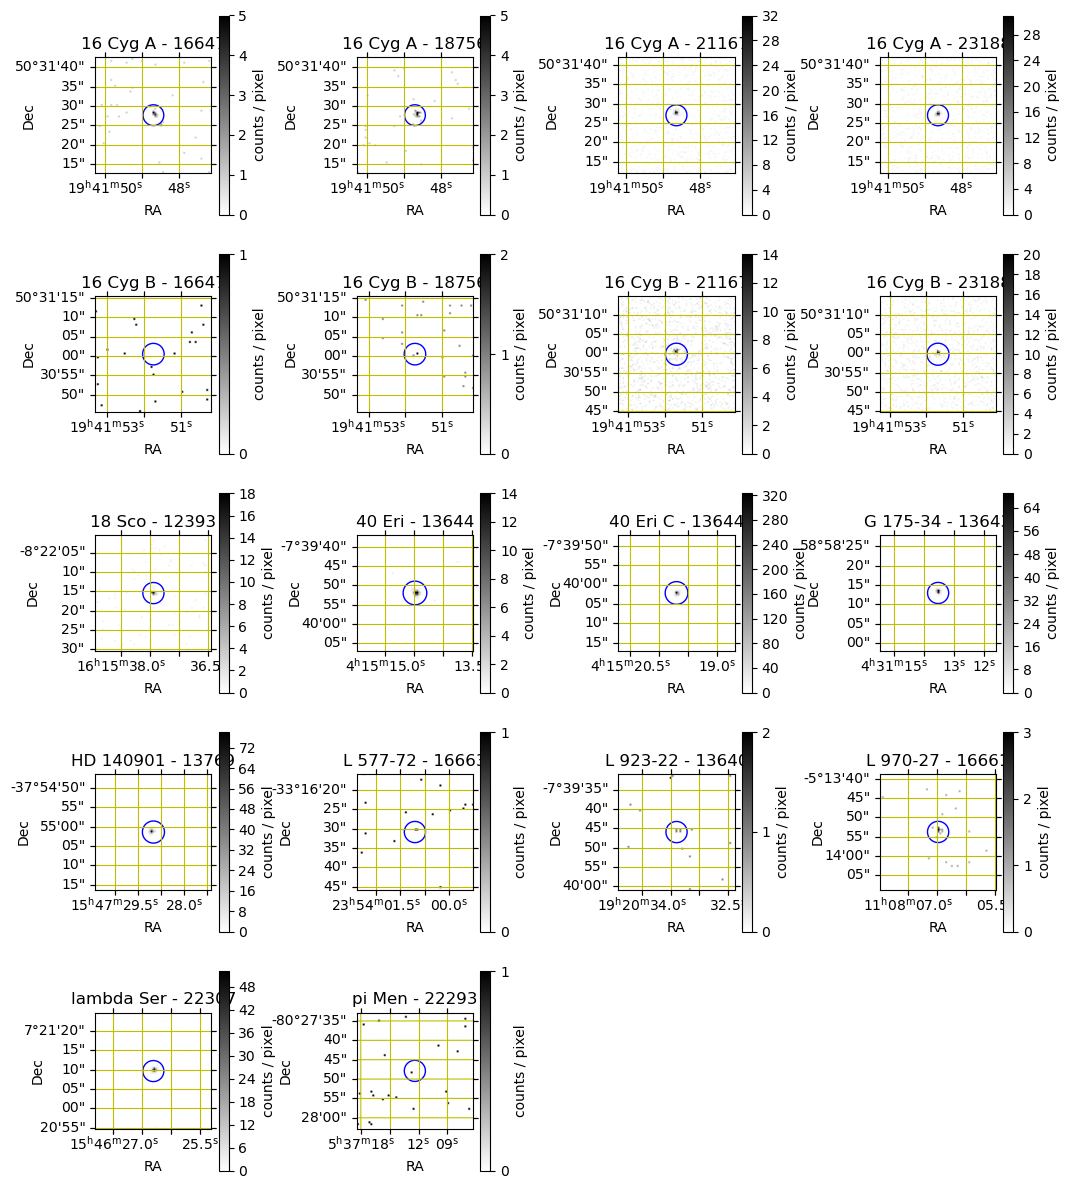

In [15]:
fig = plt.figure(figsize=(12, 15))
for i, row in enumerate(chandra_obs):
    coord = row['coord']
    hdu = fits.open(f"data/ages/{row['object'].replace(' ', '_')}_{row['ObsId']}_image.fits")[0]
    wcs = WCS(hdu.header)
    ax = fig.add_subplot(5, 4, i+1, projection=wcs)
    im = ax.imshow(hdu.data, origin='lower', cmap=plt.get_cmap('binary'), 
                   # Ensure that the color bar spans at least 0..1 even if there are no counts
                   vmin=0, vmax = max(1, hdu.data.max()))
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('counts / pixel')
    # Since counts are integer values, we want to label only the integers
    cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(color='y', ls='solid')
    r = SphericalCircle((coord.ra, coord.dec), 
                        chandra_helpers.psf_of_coord(f"data/ages/{row['ObsId']}", 
                                                     row['coord'],
                                                     psffrac=0.95) * u.arcsec,
                         edgecolor='b', facecolor='none',
                         transform=ax.get_transform('fk5'))
    ax.add_patch(r)
    ax.coords['ra'].set_axislabel('RA')
    ax.coords['ra'].set_ticklabel(exclude_overlapping=True)
    # minpad moves the label "Dec". A negative value moves it in a little bit.
    ax.coords['dec'].set_axislabel('Dec', minpad=-1)
    ax.set_title(f"{row['object']} - {row['ObsId']}")

fig.subplots_adjust(wspace=.8)

It looks like some of the astrometry is a bit off. In particular, when 16 Cyg A and B offset in the same directions, that's a strong hint. I visually inspected the images though and there don't seem to be enough sources to improve the astrometry from cross-matching with 2MASS. GAIA might help. Another alternative is that look at our clearly detected targets and just use those or to manually adjust the source regions. 

For now, I continue and just use a big enough extraction region so that we catch most of the PSF.

In [15]:
# Print out a table that makes it easy to me to see where I am in Ds9 to select a proper background region
for row in chandra_obs:
    print(f"{row['ObsId']:6g} - {row['object']}: {row['coord'].ra.to_string(precision=1, sep=':', unit=u.hourangle):>12s}" + 
          f" {row['coord'].dec.to_string(precision=1, sep=':', alwayssign=True):15s}")

 16647 - 16 Cyg A:   19:41:48.7 +50:31:27.7    
 18756 - 16 Cyg A:   19:41:48.7 +50:31:27.7    
 21167 - 16 Cyg A:   19:41:48.6 +50:31:27.0    
 23188 - 16 Cyg A:   19:41:48.6 +50:31:27.0    
 16647 - 16 Cyg B:   19:41:51.7 +50:31:00.5    
 18756 - 16 Cyg B:   19:41:51.7 +50:31:00.5    
 21167 - 16 Cyg B:   19:41:51.7 +50:30:59.8    
 23188 - 16 Cyg B:   19:41:51.7 +50:30:59.8    
 12393 - 18 Sco:   16:15:37.4 -8:22:15.5     
 13644 - 40 Eri:    4:15:14.5 -7:39:52.0     
 13644 - 40 Eri C:    4:15:19.7 -7:40:02.2     
 13643 - G 175-34:    4:31:13.5 +58:58:12.9    
 13769 - HD 140901:   15:47:28.7 -37:55:01.4    
 16663 - L 577-72:   23:54:00.7 -33:16:30.9    
 13640 - L 923-22:   19:20:33.4 -7:39:46.0     
 16661 - L 970-27:   11:08:06.5 -5:13:53.8     
 22307 - lambda Ser:   15:46:26.3 +7:21:09.6     
 22293 - pi Men:    5:37:12.4 -80:27:47.9    


In [16]:
# Selecting large, apparently source-free regions on the same chip (with one exception, where I used a different chip)
bkg_by_hand = {
    (12393, '18 Sco'): "circle(4066.4966,3778.345,249.91617)",
    (13640, 'L 923-22'): "circle(4359.8333,3973.5,215.45959)",
    (13643, 'G 175-34'): "circle(4211.9716,4323.6343,178.74713)",
    (13644, '40 Eri'): "circle(3767.8333,4104.8333,155.97284)", 
    (13644, '40 Eri C'): "circle(3767.8333,4104.8333,155.97284)", 
    (13769, 'HD 140901'): "circle(3968.3333,4289.1667,159.06436)", # in chip gap.
    (16647, '16 Cyg A'): "circle(4368.2685,4168.1019,152.09078)",
    (16647, '16 Cyg B'): "circle(4368.2685,4168.1019,152.09078)",
    (16661, 'L 970-27'): "circle(4356.0648,4244.7222,134.43841)",
    (16663, 'L 577-72'): "circle(4366.9444,4141.9444,211.52509)",
    (18756, '16 Cyg A'):"circle(4379.4444,4147.5,168.42297)",
    (18756, '16 Cyg B'):"circle(4379.4444,4147.5,168.42297)",
    (21167, '16 Cyg A'): 'circle(16879.708,16561.756,341.38782)',
    (21167, '16 Cyg B'): 'circle(16879.708,16561.756,341.38782)',
    (22293, 'pi Men'): "circle(4362.0463,4312.9259,199.25044)",
    (22307, 'lambda Ser'): "circle(15506.294,15742.684,808.24645)",
    (23188, '16 Cyg A'): "circle(16768.54,16673.5,304.47711)",
    (23188, '16 Cyg B'): "circle(16768.54,16673.5,304.47711)",    
}

In [53]:
for target in chandra_obs:
    chandra_helpers.specextract('data/ages', target, bkg_by_hand)

specextract for ObsID 21167
specextract for ObsID 23188
specextract for ObsID 21167
specextract for ObsID 23188
specextract for ObsID 22307


In [17]:
tabs = [chandra_helpers.dmextract_tab_and_lc('data/ages', target, bkg_by_hand)
        for target in chandra_obs]

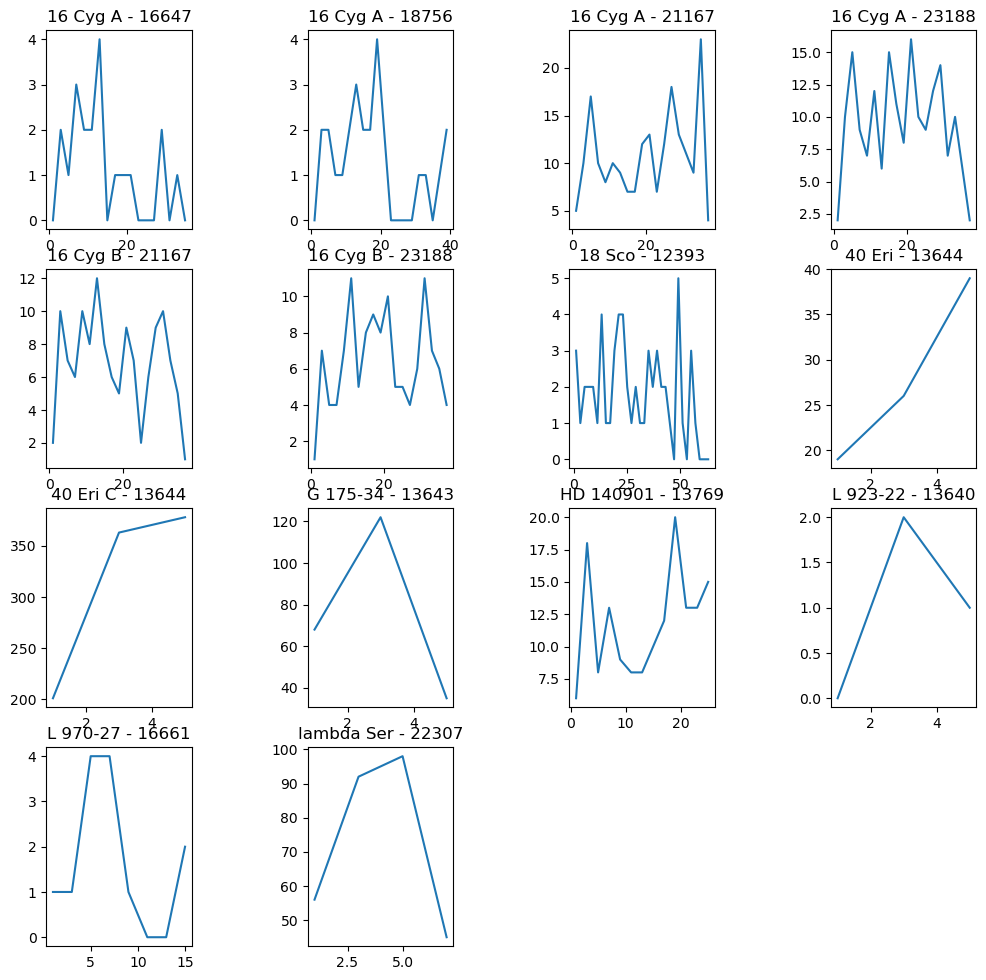

In [65]:
fig = plt.figure(figsize=(12, 15))
i = 0
for target in chandra_obs[:-1]:
    
    lcfile = f'data/ages/{target["ObsId"]}/lc_{target["object"].replace(" ", "_")}.fits'
    lc = table.Table.read(lcfile, hdu=1)
    if lc['COUNTS'].sum() > 3:
        ax = fig.add_subplot(5, 4, i+1)
        ax.plot((lc['TIME'][:-1] - lc['TIME_MIN'][0]) / 1e3, 
                lc['COUNTS'][:-1])
        ax.set_title(f"{target['object']} - {target['ObsId']}")
        i += 1

fig.subplots_adjust(wspace=.8)

In [19]:
tabs = table.vstack(tabs, metadata_conflicts='silent')
chandra_obs = table.hstack([chandra_obs, tabs])

In [21]:
chandra_helpers.run_ap_limits(chandra_obs)

In [22]:
chandra_obs['AREA'].format = '{:.1f}'
chandra_obs['BG_AREA'].format = '{:.0f}'
chandra_obs['Upper limit'].format = '{:.1e}'
for col in ['COUNTS', 'BG_COUNTS']:
    chandra_obs[col] = chandra_obs[col].astype(int)

In [23]:
chandra_obs['object', 'ObsId', 'Instrument', 'Exposure', 'off_axis_angle', 'COUNTS', 'BG_COUNTS', 'BG_AREA', 'AREA', 'Detection threshold', 'Upper limit']

object,ObsId,Instrument,Exposure,off_axis_angle,COUNTS,BG_COUNTS,BG_AREA,AREA,Detection threshold,Upper limit
,,,,arcmin,ct,ct,pix2,pix2,,ct / s
str11,int64,str6,float64,float64,float64,float64,float64,float64,int64,float64
16 Cyg A,16647,ACIS-I,35.33,0.56,20.0,532.0,72670,93.5,2,5.6e-05
16 Cyg A,18756,ACIS-I,38.57,0.56,26.0,681.0,89115,93.5,2,5.1e-05
16 Cyg A,21167,HRC-I,35.05,0.22,205.0,9310.0,366139,1326.7,41,2.3e-04
16 Cyg A,23188,HRC-I,35.31,0.23,181.0,6958.0,291245,1326.9,39,2.3e-04
16 Cyg B,16647,ACIS-I,35.33,0.13,1.0,532.0,72670,100.5,2,5.5e-05
16 Cyg B,18756,ACIS-I,38.57,0.13,3.0,681.0,89115,100.4,2,4.9e-05
16 Cyg B,21167,HRC-I,35.05,0.63,130.0,9310.0,366139,1465.2,45,2.4e-04
16 Cyg B,23188,HRC-I,35.31,0.64,122.0,6958.0,291245,1466.5,43,2.4e-04


In [54]:
for target in chandra_obs:
    ui.load_data(f'{target["ObsId"]} - {target["object"]}', 
                 f'data/ages/{target["ObsId"]}/spec_{target["object"].replace(" ", "_")}.pi')

read ARF file data/ages/16647/spec_16_Cyg_A.corr.arf
read RMF file data/ages/16647/spec_16_Cyg_A.rmf
read ARF (background) file data/ages/16647/spec_16_Cyg_A.corr.arf
read RMF (background) file data/ages/16647/spec_16_Cyg_A.rmf
read background file data/ages/16647/spec_16_Cyg_A_bkg.pi
read ARF file data/ages/18756/spec_16_Cyg_A.corr.arf
read RMF file data/ages/18756/spec_16_Cyg_A.rmf
read ARF (background) file data/ages/18756/spec_16_Cyg_A.corr.arf
read RMF (background) file data/ages/18756/spec_16_Cyg_A.rmf
read background file data/ages/18756/spec_16_Cyg_A_bkg.pi
read ARF file data/ages/21167/spec_16_Cyg_A.corr.arf
read RMF file data/ages/21167/spec_16_Cyg_A.rmf
read ARF (background) file data/ages/21167/spec_16_Cyg_A.corr.arf
read RMF (background) file data/ages/21167/spec_16_Cyg_A.rmf
read background file data/ages/21167/spec_16_Cyg_A_bkg.pi
read ARF file data/ages/23188/spec_16_Cyg_A.corr.arf
read RMF file data/ages/23188/spec_16_Cyg_A.rmf
read ARF (background) file data/ages/2318

In [55]:
ui.set_analysis('energy')


dataset 12393 - 18 Sco: 0.0073:14.9504 Energy (keV)
dataset 13640 - L 923-22: 0.0073:14.9504 Energy (keV)
dataset 13643 - G 175-34: 0.0073:14.9504 Energy (keV)
dataset 13644 - 40 Eri: 0.0073:14.9504 Energy (keV)
dataset 13644 - 40 Eri C: 0.0073:14.9504 Energy (keV)
dataset 13769 - HD 140901: 0.0073:14.9504 Energy (keV)
dataset 16647 - 16 Cyg A: 0.0073:14.9504 Energy (keV)
dataset 16647 - 16 Cyg B: 0.0073:14.9504 Energy (keV)
dataset 16661 - L 970-27: 0.0073:14.9504 Energy (keV)
dataset 16663 - L 577-72: 0.0073:14.9504 Energy (keV)
dataset 18756 - 16 Cyg A: 0.0073:14.9504 Energy (keV)
dataset 18756 - 16 Cyg B: 0.0073:14.9504 Energy (keV)
dataset 21167 - 16 Cyg A: 0.06:10 Energy (keV)
dataset 21167 - 16 Cyg B: 0.06:10 Energy (keV)
dataset 22293 - pi Men: 0.0073:14.9504 Energy (keV)
dataset 22307 - lambda Ser: 0.06:10 Energy (keV)
dataset 23188 - 16 Cyg A: 0.06:10 Energy (keV)
dataset 23188 - 16 Cyg B: 0.06:10 Energy (keV)


dataset 16647 - 16 Cyg A: 0.0073:14.9504 -> 0.4088:14.9504 Energy (keV)
dataset 16647 - 16 Cyg A: 0.4088:14.9504 -> 0.4088:6.9934 Energy (keV)
dataset 16647 - 16 Cyg A: 0.4088:6.9934 Energy (keV) (unchanged)
Dataset               = 16647 - 16 Cyg A
Method                = levmar
Statistic             = cash
Initial fit statistic = 18.1948
Final fit statistic   = 18.1948 at function evaluation 2
Data points           = 11
Degrees of freedom    = 10
Change in statistic   = 0
   16647_-_16_Cyg_A.norm   3.22712e-06  +/- 7.28967e-07 
dataset 18756 - 16 Cyg A: 0.0073:14.9504 -> 0.4088:14.9504 Energy (keV)
dataset 18756 - 16 Cyg A: 0.4088:14.9504 -> 0.4088:6.9934 Energy (keV)
dataset 18756 - 16 Cyg A: 0.4088:6.9934 Energy (keV) (unchanged)
Dataset               = 18756 - 16 Cyg A
Method                = levmar
Statistic             = cash
Initial fit statistic = 19.7305
Final fit statistic   = 19.7305 at function evaluation 2
Data points           = 13
Degrees of freedom    = 12
Change in sta

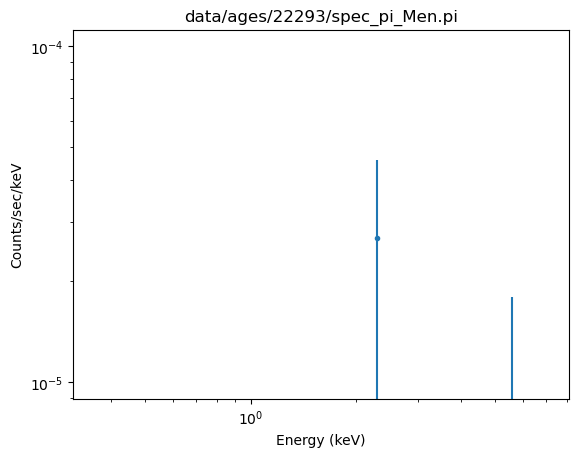

In [56]:
chandra_obs['flux'] = 0.
chandra_obs['fluxlow'] = 0.
chandra_obs['fluxhigh'] = 0.
for f in ['flux', 'fluxlow', 'fluxhigh']:
    chandra_obs[f].format = '{:.1e}'

for target in chandra_obs:
    idname = f'{target["ObsId"]} - {target["object"]}'
    if target['Instrument'].startswith('ACIS'):
        ui.ignore_id(idname, None, 0.4)
    else:
        ui.ignore_id(idname, None, 0.1)
    ui.ignore_id(idname, 7, None)
    counts = ui.get_data(idname).counts.sum()
    
    # make sure both references exist
    ui.set_source(idname, ui.xsapec.a1 + ui.xsapec.a2)
    
    if (counts > 500) and target['Instrument'].startswith('ACIS'):
        ui.set_stat("chi2gehrels")
        model = ui.xsapec(name=idname.replace(" ", "_")+'_1') + ui.xsapec(name=idname.replace(" ", "_")+ '_2')
        ui.set_source(idname, model)
        ui.group_counts(idname, 15)
        ui.subtract(idname)
    
    elif counts > 50:
        ui.set_stat("chi2gehrels")
        model = ui.xsapec(name=idname.replace(" ", "_"))
        ui.set_source(idname, model)
        ui.group_counts(idname, 5)
        ui.subtract(idname)
    elif counts > 5:
        model = ui.xsapec(name=idname.replace(" ", "_"))
        ui.set_stat("cash")
        ui.unsubtract(idname)
        ui.set_source(idname, model)
        ui.group_counts(idname, 2)
        model.kT = 0.5
        model.kT.frozen = True
    else:
        continue
    if target['Instrument'].startswith('HRC'):
        model.kT = 0.5
        model.kT.frozen = True
    
    ui.fit(idname)
    ui.plot_fit(idname, xlog=True, ylog=True)
    cvals = ui.sample_energy_flux(0.4, 7, num=1000, id=idname, 
                                      model=ui.get_source(idname))
    flow, f, fhigh = np.percentile(cvals[:, 0], [5, 50, 95])
    target['flux'] = f
    target['fluxlow'] = flow
    target['fluxhigh'] = fhigh
    

This table is pretty close to science ready. 


If a source is detected, ognore the upper limits. They are just here for debugging. I want to see that the f with a detected soure are self-consistent.

There are some cosmatical improvements (e.g. you unicode.latex for Greek letters) and some teaks we can discuss, in particular what energy bands to use. 

In [57]:
model = ui.xsapec(name='model')
model.kT = 0.5
model.norm = 1e-3

for kT in [0.15, .5, 1.]:
    model.kT = kT
    chandra_obs[f'limit_{kT}'] = [model_helpers.count_rate_to_flux(f'{target["ObsId"]} - {target["object"]}', 
                                                                   model, row['Upper limit'], lo=0.4, hi=7.) for row in chandra_obs]
    chandra_obs[f'limit_{kT}'].format = '{:.1e}'

In [58]:
undetected = chandra_obs['COUNTS'] <= chandra_obs['Detection threshold']
for col in ['flux', 'fluxlow', 'fluxhigh']:
    chandra_obs[col][undetected] = np.nan

In [59]:
not_fitted = chandra_obs['flux'] == 0.

scale = chandra_obs['COUNTS'][not_fitted] / chandra_obs['Detection threshold'][not_fitted]
chandra_obs['flux'][not_fitted] = chandra_obs['limit_0.5'][not_fitted] * scale
chandra_obs['fluxhigh'][not_fitted] = chandra_obs['flux'][not_fitted] * (1 + np.sqrt(1 / chandra_obs['COUNTS'][not_fitted]))
chandra_obs['fluxlow'][not_fitted] = chandra_obs['flux'][not_fitted] * (1 - np.sqrt(1 / chandra_obs['COUNTS'][not_fitted]))


In [60]:
chandra_obs['object', 'ObsId', 'Instrument', 'Exposure', 'off_axis_angle', 
            'COUNTS', 'BG_COUNTS', 'BG_AREA', 'AREA', 'Detection threshold', 'Upper limit',
            'flux', 'fluxlow', 'fluxhigh', 
            'limit_0.15', 'limit_0.5', 'limit_1.0']

object,ObsId,Instrument,Exposure,off_axis_angle,COUNTS,BG_COUNTS,BG_AREA,AREA,Detection threshold,Upper limit,flux,fluxlow,fluxhigh,limit_0.15,limit_0.5,limit_1.0
,,,,arcmin,ct,ct,pix2,pix2,,ct / s,,,,erg / (s cm2),erg / (s cm2),erg / (s cm2)
str11,int64,str6,float64,float64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
16 Cyg A,16647,ACIS-I,35.33,0.56,20,532,72670,93.5,2,5.6e-05,9.2e-15,6.1e-15,1.3e-14,5.9e-15,1.1e-15,6.3e-16
16 Cyg A,18756,ACIS-I,38.57,0.56,26,681,89115,93.5,2,5.1e-05,1.1e-14,7.5e-15,1.5e-14,5.2e-15,9.8e-16,6.0e-16
16 Cyg A,21167,HRC-I,35.05,0.22,205,9310,366139,1326.7,41,2.3e-04,4.6e-15,1.3e-15,8.3e-15,2.3e-14,4.4e-15,2.6e-15
16 Cyg A,23188,HRC-I,35.31,0.23,181,6958,291245,1326.9,39,2.3e-04,2.1e-15,0.0e+00,5.0e-15,2.3e-14,4.1e-15,2.6e-15
16 Cyg B,16647,ACIS-I,35.33,0.13,1,532,72670,100.5,2,5.5e-05,nan,nan,nan,5.7e-15,1.1e-15,6.1e-16
16 Cyg B,18756,ACIS-I,38.57,0.13,3,681,89115,100.4,2,4.9e-05,1.4e-15,6.0e-16,2.3e-15,5.0e-15,9.5e-16,5.7e-16
16 Cyg B,21167,HRC-I,35.05,0.63,130,9310,366139,1465.2,45,2.4e-04,4.1e-15,5.2e-16,7.5e-15,2.5e-14,4.5e-15,2.7e-15
16 Cyg B,23188,HRC-I,35.31,0.64,122,6958,291245,1466.5,43,2.4e-04,4.1e-15,8.5e-16,7.4e-15,2.5e-14,4.8e-15,2.8e-15


This is the final table with fluxes. It lists both the fitted fluxes for those targets that have enough counts and the upper limits that would correspond to the detection limit. Of course, for detected source, there is no need to look at the upper limits and for non-detected sources, the fitted fluxes are useless.
There are, however, a few cases where the source is formally detected with 3 counts, but I still can't get a good flux from a fit. In that case, it's still useful to see the "upper limit" that corresponds to the detection limit. So, if the detection limit is 2 counts, and we detected it at three counts, then I can get an estimate for the source flux by looking at the "upper limit" and multiplying with 3/2.

So, this table is put together in different regimes:
- For bright sources, it's a 2 T fit
- for HRC it's fiximg T at some number
- for medium ACIS, it's a 1 T fit
- for faint ACIS, it's based on the upper limit for 0.5 keV and scaled
- for undetected, it's just upper limits.

Exact numbers my change if we change either the temperature of the fiducial model or the bandwith over which we report the fluxes (currently 0.4 - 7 keV)
